# Data Sanity of final data 

- load final_data.csv
- check if there are any suspicious missing values

In [1]:
import pandas as pd 

# Function to load a CSV file
def load_csv_file(file_path):
    """Loads a CSV file into a pandas DataFrame and returns it."""
    try:
        df = pd.read_csv(file_path)
        # print(f"Successfully loaded '{file_path}'. Head of the DataFrame:")
        # print(df.head())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None


In [2]:
data = load_csv_file("data/final_data.csv")
data.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
0,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
1,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
2,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
3,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN


In [3]:
# Ensure datetime
data["t10"] = pd.to_datetime(data["t10"])

# Extract ISO year and week
iso = data["t10"].dt.isocalendar()
data["iso_year"] = iso.year
data["iso_week"] = iso.week
data["weekday"] = data["t10"].dt.weekday


In [4]:
# periods
winter_exam_phase = data[ data["iso_week"].between(3, 8)].copy()
summer_exam_phase = data[data["iso_week"].between(29, 32)].copy()

In [5]:
expected_p1 = (
    winter_exam_phase[["iso_week", "weekday"]]
    .drop_duplicates()
    .sort_values(["iso_week", "weekday"])
)


In [6]:
grid_p1 = (
    expected_p1
    .assign(key=1)
    .merge(
        pd.DataFrame(
            {"location_id": winter_exam_phase["location_id"].unique(), "key": 1}
        ),
        on="key"
    )
    .drop(columns="key")
)


In [7]:
observed_p1 = (
    winter_exam_phase
    .dropna(subset=["relative_availability"])
    [["location_id", "iso_week", "weekday"]]
    .drop_duplicates()
)



In [8]:
grid_p1 = grid_p1.merge(
    observed_p1,
    on=["location_id", "iso_week", "weekday"],
    how="left",
    indicator=True
)

grid_p1["missing"] = (grid_p1["_merge"] == "left_only").astype(int)

grid_p1 = (
    grid_p1
    .groupby(["location_id", "iso_week", "weekday"], as_index=False)["missing"]
    .max()
)


In [9]:
weekday_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sa", 6: "So"}

grid_p1["x_label"] = (
    "W" + grid_p1["iso_week"].astype(str).str.zfill(2) + " " +
    grid_p1["weekday"].map(weekday_map)
)

grid_p1["x_order"] = grid_p1["iso_week"] * 10 + grid_p1["weekday"]




In [10]:
heat_p1 = pd.pivot_table(
    grid_p1,
    index="location_id",
    columns="x_label",
    values="missing",
    aggfunc="max"   # collapse any remaining duplicates
)


In [11]:
grid_p1.groupby(
    ["location_id", "iso_week", "weekday"]
).size().sort_values(ascending=False).head(10)




location_id  iso_week  weekday
3            3         0          1
14           7         3          1
             6         2          1
                       3          1
                       4          1
                       5          1
                       6          1
             7         0          1
                       1          1
                       2          1
dtype: int64

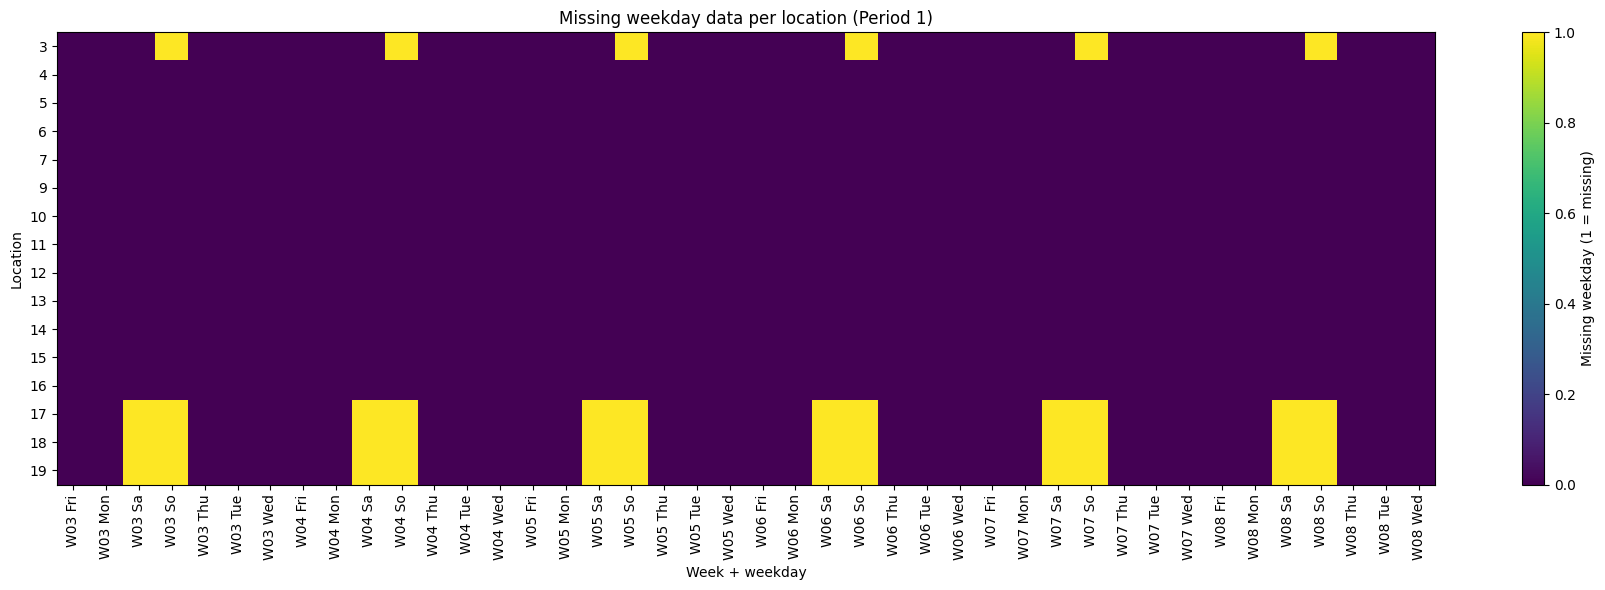

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(18, 6))

im = ax.imshow(heat_p1.values, aspect="auto")

ax.set_yticks(np.arange(len(heat_p1.index)))
ax.set_yticklabels(heat_p1.index)

ax.set_xticks(np.arange(len(heat_p1.columns)))
ax.set_xticklabels(heat_p1.columns, rotation=90)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Missing weekday (1 = missing)")

ax.set_title("Missing weekday data per location (Period 1)")
ax.set_xlabel("Week + weekday")
ax.set_ylabel("Location")

plt.tight_layout()
plt.show()


#### Winter exam phase
- only missing data on weekends of location 3, 17, 18, 19 due to closing on weekends 
- no suspicious missing values which aren't explainable 

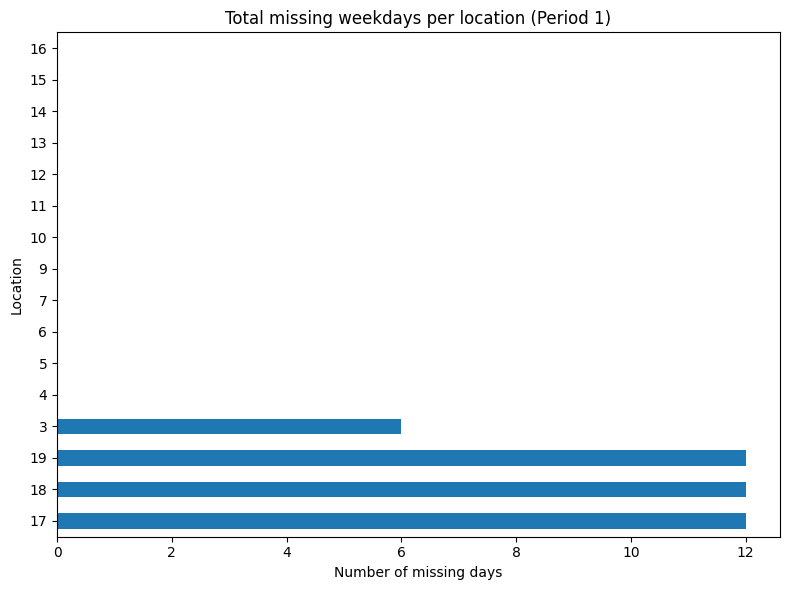

In [13]:
missing_count = heat_p1.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_count.plot(kind="barh")
plt.xlabel("Number of missing days")
plt.ylabel("Location")
plt.title("Total missing weekdays per location (Period 1)")
plt.tight_layout()
plt.show()


In [14]:
expected_p2 = (
    summer_exam_phase[["iso_week", "weekday"]]
    .drop_duplicates()
    .sort_values(["iso_week", "weekday"])
)


In [15]:
grid_p2 = (
    expected_p2
    .assign(key=1)
    .merge(
        pd.DataFrame(
            {"location_id": summer_exam_phase["location_id"].unique(), "key": 1}
        ),
        on="key"
    )
    .drop(columns="key")
)


In [16]:
observed_p2 = (
    summer_exam_phase
    .dropna(subset=["relative_availability"])
    [["location_id", "iso_week", "weekday"]]
    .drop_duplicates()
)


In [17]:
grid_p2 = grid_p2.merge(
    observed_p2,
    on=["location_id", "iso_week", "weekday"],
    how="left",
    indicator=True
)

grid_p2["missing"] = (grid_p2["_merge"] == "left_only").astype(int)

grid_p2 = (
    grid_p2
    .groupby(["location_id", "iso_week", "weekday"], as_index=False)["missing"]
    .max()
)

In [18]:
weekday_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sa", 6: "So"}

grid_p2["x_label"] = (
    "W" + grid_p2["iso_week"].astype(str).str.zfill(2) + " " +
    grid_p2["weekday"].map(weekday_map)
)

grid_p2["x_order"] = grid_p2["iso_week"] * 10 + grid_p2["weekday"]

In [19]:
heat_p2 = pd.pivot_table(
    grid_p2,
    index="location_id",
    columns="x_label",
    values="missing",
    aggfunc="max"   # collapse any remaining duplicates
)

In [20]:
grid_p2.groupby(
    ["location_id", "iso_week", "weekday"]
).size().sort_values(ascending=False).head(10)

location_id  iso_week  weekday
3            29        0          1
                       1          1
14           32        5          1
                       4          1
                       3          1
                       2          1
                       1          1
                       0          1
             31        6          1
                       5          1
dtype: int64

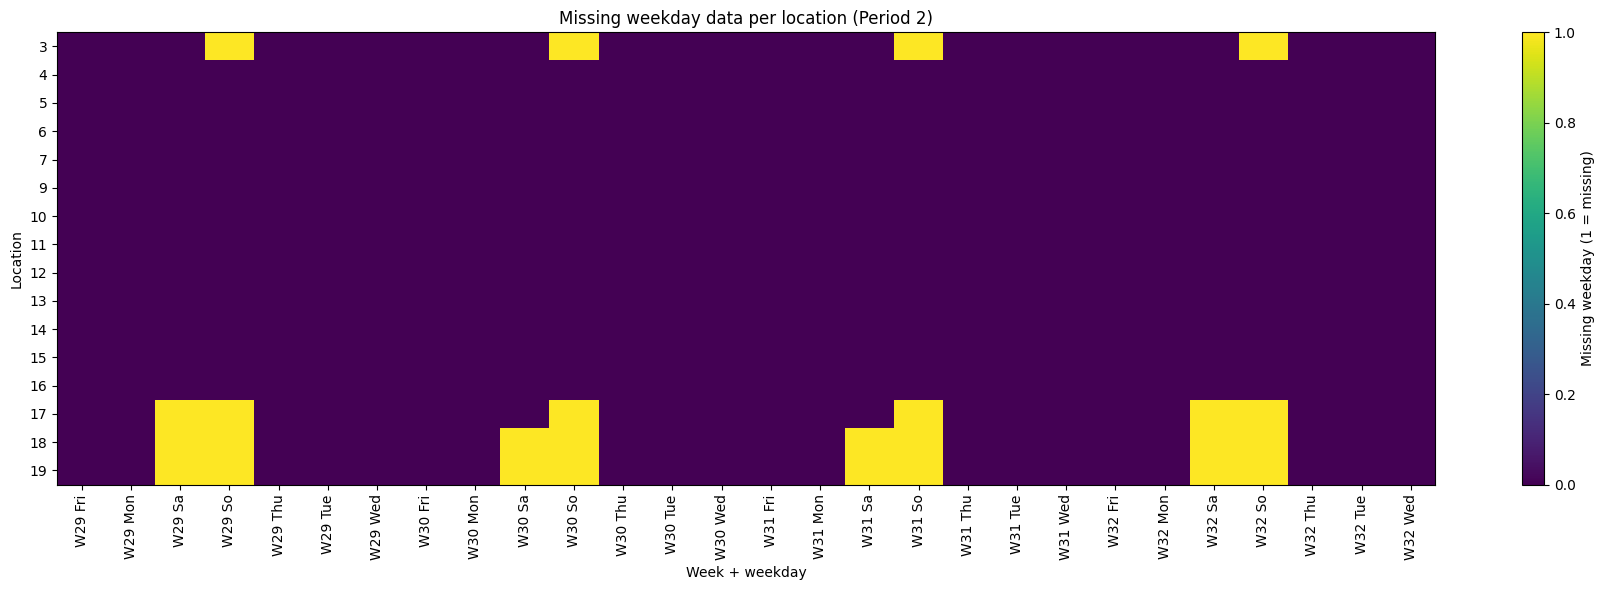

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(18, 6))

im = ax.imshow(heat_p2.values, aspect="auto")

ax.set_yticks(np.arange(len(heat_p2.index)))
ax.set_yticklabels(heat_p2.index)

ax.set_xticks(np.arange(len(heat_p2.columns)))
ax.set_xticklabels(heat_p2.columns, rotation=90)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Missing weekday (1 = missing)")

ax.set_title("Missing weekday data per location (Period 2)")
ax.set_xlabel("Week + weekday")
ax.set_ylabel("Location")

plt.tight_layout()
plt.show()


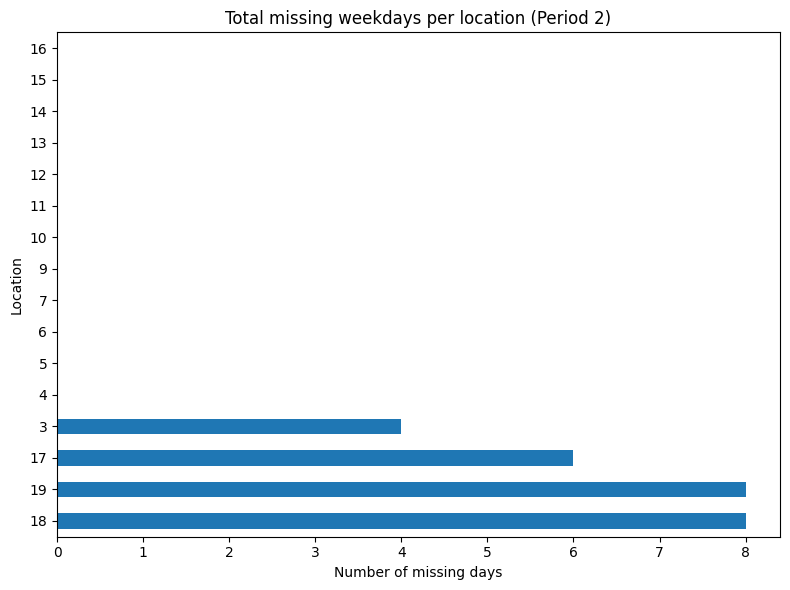

In [23]:
missing_count = heat_p2.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_count.plot(kind="barh")
plt.xlabel("Number of missing days")
plt.ylabel("Location")
plt.title("Total missing weekdays per location (Period 2)")
plt.tight_layout()
plt.show()


### Summer exam phase 
- no suspicious missing values as well 
- only on weekends because of clousure 